## Species distribution models using random forest to predictthe most suitable habitat, then interpreted with package` lime`

> predict 3 most suitable geo-habitats for White-breasted waterhen (*Amaurornis phoenicurus*)
![](http://oknation.nationtv.tv/blog/home/blog_data/671/3671/images/mom2.jpg)

## Load required libraries

In [1]:
library(sdmbench)
library(mlr)
library(iml)
library(lime)
library(dplyr)
library(rsample)
library(latticeExtra)
library(sp)
library(ggplot2)

sdmbench: Tools for benchmarking Species Distribution Models 
For more information visit http://github.com/ 
To start the GUI: run_sdmbench()

Loading required package: ParamHelpers

'mlr' is in maintenance mode since July 2019. Future development
efforts will go into its successor 'mlr3' (<https://mlr3.mlr-org.com>).


Attaching package: 'dplyr'


The following object is masked from 'package:lime':

    explain


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: 'ggplot2'


The following object is masked from 'package:latticeExtra':

    layer




## Get and prepare data 

In [2]:
occ_data_raw <-
  get_benchmarking_data("Amaurornis phoenicurus", limit = 500)


occ_data <- occ_data_raw$df_data

occ_data$label <- as.factor(occ_data$label)

coordinates_df <- rbind(occ_data_raw$raster_data$coords_presence,
                        occ_data_raw$raster_data$background)

occ_data <-
  normalizeFeatures(occ_data, method = "standardize")

occ_data <- cbind(occ_data, coordinates_df)
occ_data <- na.omit(occ_data)

[1] "Getting benchmarking data...."
[1] "Cleaning benchmarking data...."


Registered S3 method overwritten by 'hoardr':
  method           from
  print.cache_info httr

Assuming 'decimalLatitude' is latitude

Assuming 'decimalLongitude' is longitude



[1] "Done!"


## Split data for machine learning 

In [3]:
set.seed(99)
train_test_split <- initial_split(occ_data, prop = 0.7)
data_train <- training(train_test_split)
data_test  <- testing(train_test_split)
data_train$x <- NULL
data_train$y <- NULL
data_test_subset <- data_test %>% filter(label == 1)

## Train model 

In [4]:
task <-
  makeClassifTask(id = "model", data = data_train, target = "label")
lrn <- makeLearner("classif.randomForest", predict.type = "prob")
mod <- train(lrn, task)
pred <- predict(mod, newdata=data_test)
VIMP <- as.data.frame(getFeatureImportance(mod)$res)


### - Top 5 important variables

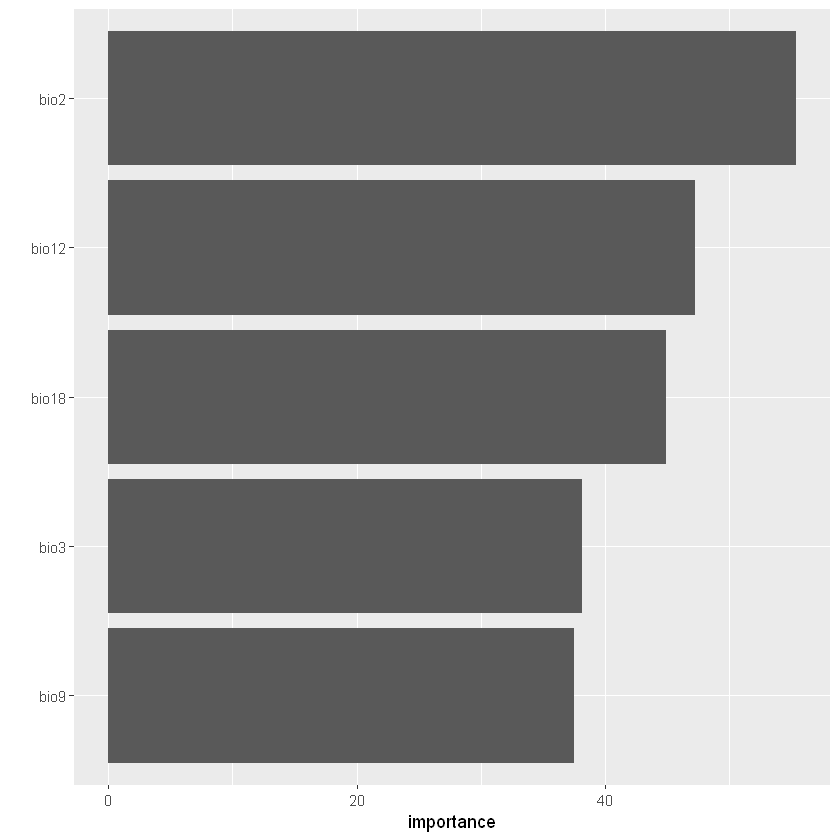

In [5]:
top_n(VIMP, n=5, importance) %>%
  ggplot(., aes(x=reorder(variable,importance), y=importance))+
  geom_bar(stat='identity')+ coord_flip() + xlab("")

### - Performance

In [6]:
performance(pred, measures=auc)


auc 
0.9667911

## ALE plot

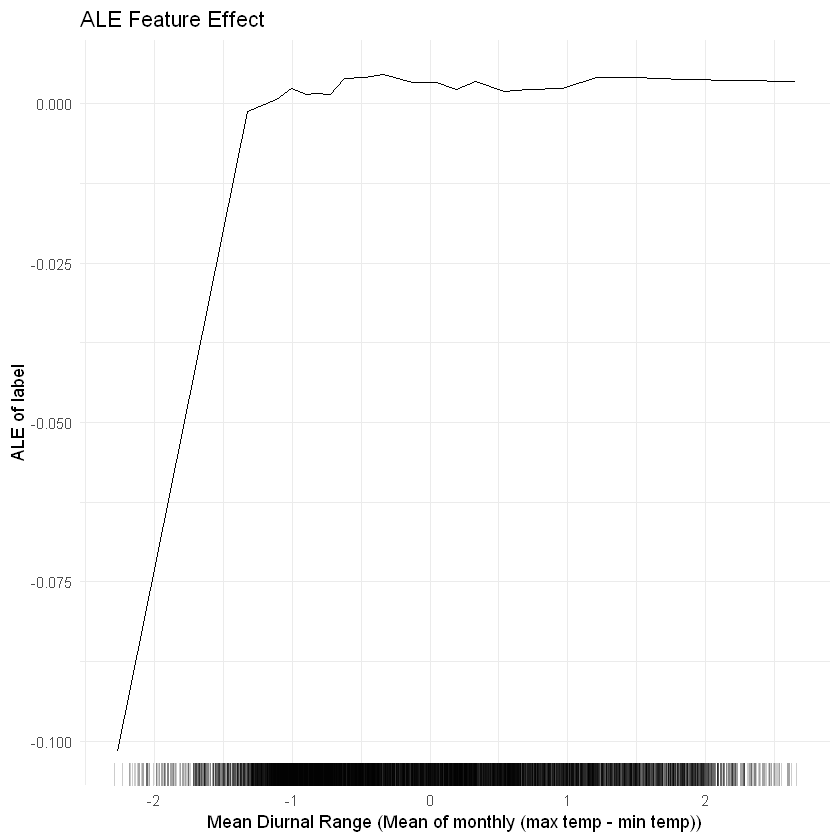

In [13]:
predictor <-
  Predictor$new(mod, data = data_train, class = 1, y = "label")
ale <- FeatureEffect$new(predictor, feature = "bio2")
ale$plot() +
  theme_minimal() +
  ggtitle("ALE Feature Effect") +
  xlab("Mean Diurnal Range (Mean of monthly (max temp - min temp))")

## Generate explanations and resampling

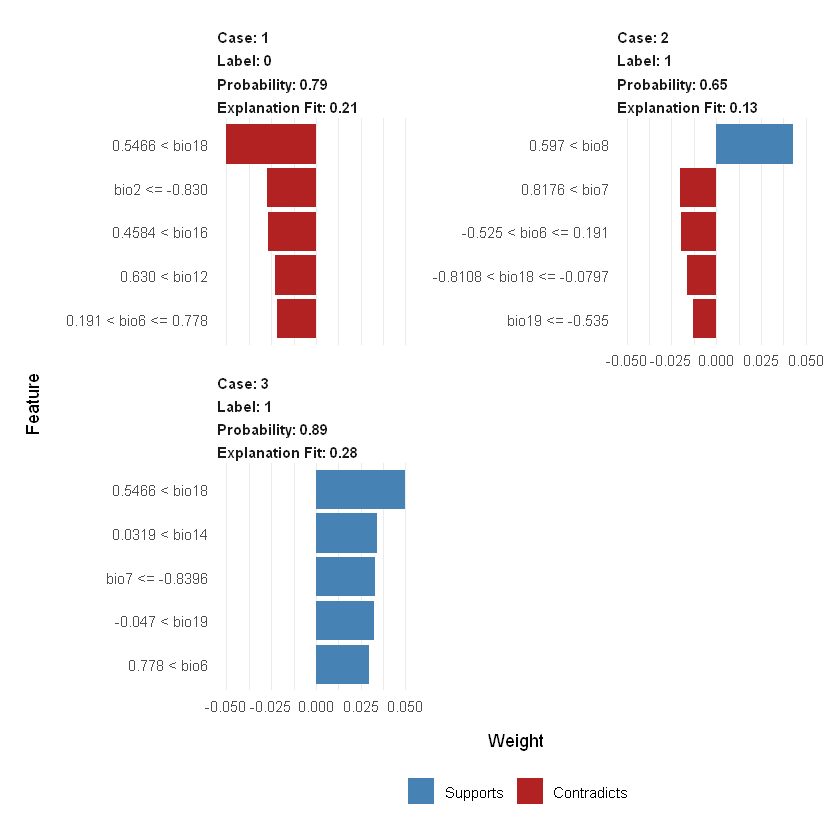

In [8]:
sample_data <- withr::with_seed(1, sample_n(data_test_subset, 3))
sample_data_coords <- dplyr::select(sample_data, c("x", "y"))
sample_data$x <- NULL
sample_data$y <- NULL


set.seed(42)
explainer <- lime(data_train, mod)
set.seed(42)
explanation <-
  lime::explain(sample_data,
                explainer,
                n_labels = 1,
                n_features = 5)
plot_features(explanation)

In [9]:
customPredictFun <- function(model, data) {
  v <- predict(model, data, type = "prob")
  v <- as.data.frame(v)
  colnames(v) <- c("absence", "presence")
  return(v$presence)
}

normalized_raster <- RStoolbox::normImage(occ_data_raw$raster_data$climate_variables)
names(normalized_raster) <- names(occ_data_raw$raster_data$climate_variables)
pr <-
  dismo::predict(normalized_raster,
                 mlr::getLearnerModel(mod, TRUE),
                 fun = customPredictFun)


## Plot on the map

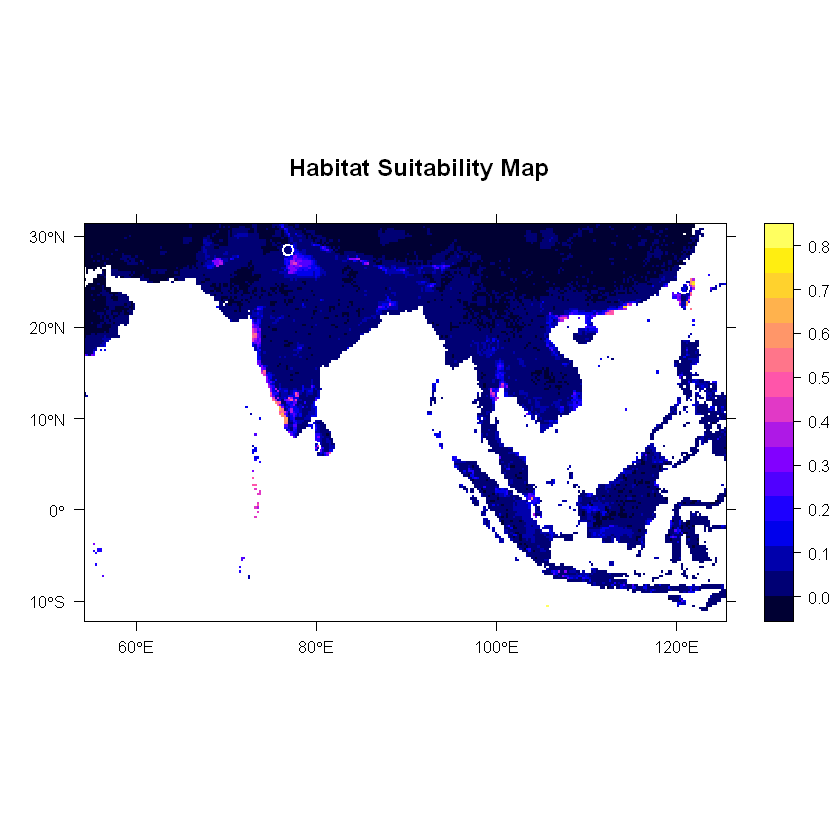

In [10]:
coordinates(sample_data_coords) <- ~ x + y
rf_map <-
  spplot(pr, main = "Habitat Suitability Map",
         scales = list(draw = TRUE),
         sp.layout = list("sp.points", sample_data_coords, pch=1, cex=1.2, lwd=2, col="white"))
rf_map